In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("SICK.txt", sep="\t")
# 只保留所需欄位: sentence_A, sentence_B, entailment_label
df = df[["sentence_A", "sentence_B", "entailment_label"]]
print("原始資料形狀:", df.shape)

df["entailment_label"] = df["entailment_label"].str.lower()
label2id = {"contradiction": 0, "entailment": 1, "neutral": 2}
df["label_id"] = df["entailment_label"].map(label2id)

df["text"] = df["sentence_A"] + " " + df["sentence_B"]

# 使用 stratified split 分成 80% 訓練 / 20% 測試
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df["label_id"], 
    random_state=42
)
print("訓練集形狀:", train_df.shape, "測試集形狀:", test_df.shape)


vectorizer = CountVectorizer()

# 先在完整訓練集上 fit，再 transform
vectorizer.fit(train_df["text"])
X_test_full = vectorizer.transform(test_df["text"]).toarray()
y_test = test_df["label_id"].values

原始資料形狀: (9840, 3)
訓練集形狀: (7872, 5) 測試集形狀: (1968, 5)



[比例 1.0] 訓練資料筆數: 7872
Test Accuracy: 0.5523
               precision    recall  f1-score   support

contradiction       0.38      0.52      0.44       285
   entailment       0.48      0.38      0.42       564
      neutral       0.64      0.65      0.64      1119

     accuracy                           0.55      1968
    macro avg       0.50      0.51      0.50      1968
 weighted avg       0.56      0.55      0.55      1968

Confusion Matrix:
[[147  11 127]
 [ 68 212 284]
 [172 219 728]]


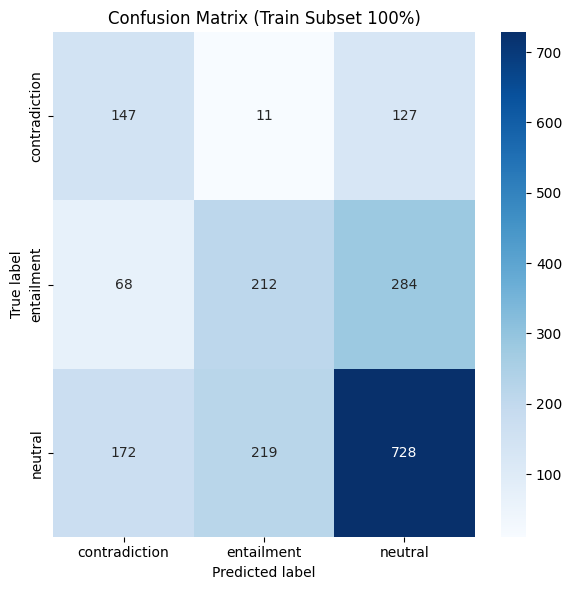


[比例 0.5] 訓練資料筆數: 3936
Test Accuracy: 0.5432
               precision    recall  f1-score   support

contradiction       0.41      0.44      0.42       285
   entailment       0.43      0.34      0.38       564
      neutral       0.62      0.67      0.64      1119

     accuracy                           0.54      1968
    macro avg       0.49      0.48      0.48      1968
 weighted avg       0.53      0.54      0.54      1968

Confusion Matrix:
[[124  15 146]
 [ 55 193 316]
 [127 240 752]]


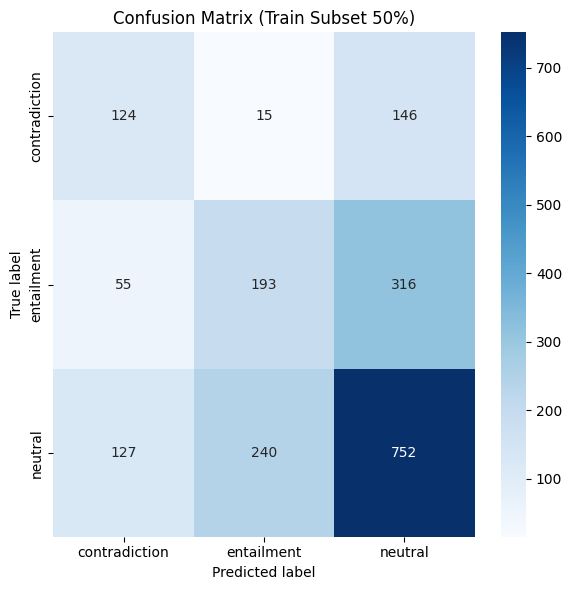


[比例 0.25] 訓練資料筆數: 1968
Test Accuracy: 0.5467
               precision    recall  f1-score   support

contradiction       0.39      0.35      0.37       285
   entailment       0.42      0.29      0.34       564
      neutral       0.61      0.73      0.67      1119

     accuracy                           0.55      1968
    macro avg       0.48      0.45      0.46      1968
 weighted avg       0.53      0.55      0.53      1968

Confusion Matrix:
[[100  16 169]
 [ 57 161 346]
 [ 97 207 815]]


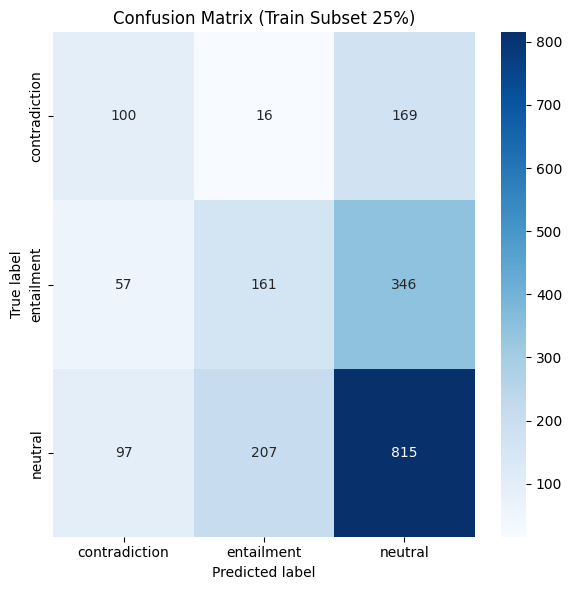


[比例 0.1] 訓練資料筆數: 787
Test Accuracy: 0.5554
               precision    recall  f1-score   support

contradiction       0.40      0.21      0.27       285
   entailment       0.43      0.28      0.34       564
      neutral       0.60      0.78      0.68      1119

     accuracy                           0.56      1968
    macro avg       0.48      0.42      0.43      1968
 weighted avg       0.52      0.56      0.52      1968

Confusion Matrix:
[[ 59  20 206]
 [ 36 158 370]
 [ 51 192 876]]


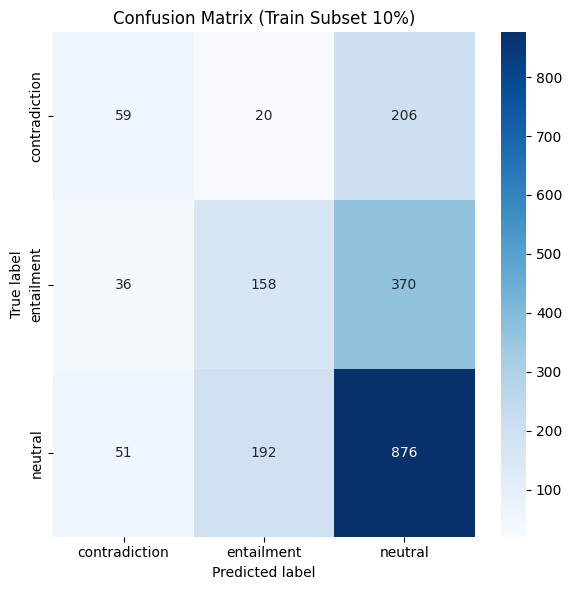

In [5]:
fractions = [1.0, 0.5, 0.25, 0.1]

for frac in fractions:
    # 抽取對應比例的訓練資料
    num_samples = int(len(train_df) * frac)
    train_subset = train_df.iloc[:num_samples]
    
    # Vectorize
    X_train_subset = vectorizer.transform(train_subset["text"]).toarray()
    y_train_subset = train_subset["label_id"].values
    
    print(f"\n[比例 {frac}] 訓練資料筆數: {num_samples}")
    
    # 建立並訓練 Naive Bayes 模型
    model = MultinomialNB()
    model.fit(X_train_subset, y_train_subset)
    
    # 在測試集上做預測
    y_pred = model.predict(X_test_full)
    
    # 計算 accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    
    # 輸出分類報告
    target_names = ["contradiction", "entailment", "neutral"]
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    import seaborn as sns
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix (Train Subset {int(frac*100)}%)")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()
